### CNN model of Digit Recognizer using Pytorch

Hoon Kim (id : KeyboardWarrior6969)


**1. Introduction**

**2. Data Preparation**

- 2.1 Load Data
- 2.2 Check for Null and missing Values


## 1. Introduction
The aim of this notebook is to showcase a simple CNN build using the
Pytorch framework.

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
%matplotlib inline

np.random.seed(2)
sns.set(style = 'white', context= 'notebook', palette = 'deep')

## 2. Data Preparation

### 2.1 Load Data

In [6]:
# Load the data
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

### 2.2 Check for null and missing values

In [7]:
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [8]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### 2.3 Data Label Distribution and Splitting

c:\users\hoon\pycharmprojects\digitrec_real\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

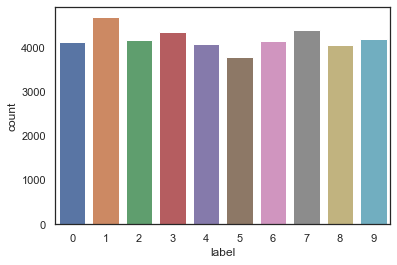

In [9]:
Y_train = train['label'] #extract labels
X_train = train.drop(labels = ['label'], axis = 1) # drop labels
del train # free memory

g = sns.countplot(Y_train)
g
